# Data Visualization project: Airline Safety

### Purpose: find interesting information and explore if an airline is risky to travel in?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

#### We start off by loading the dataset and taking a look at the features available to us.

In [2]:
url = "https://raw.githubusercontent.com/fivethirtyeight/data/master/airline-safety/airline-safety.csv"
df = pd.read_csv(url)

In [4]:
df.head()

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot*,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0
3,Aeromexico*,596871813,3,1,64,5,0,0
4,Air Canada,1865253802,2,0,0,2,0,0


In [5]:
df.columns

Index(['airline', 'avail_seat_km_per_week', 'incidents_85_99',
       'fatal_accidents_85_99', 'fatalities_85_99', 'incidents_00_14',
       'fatal_accidents_00_14', 'fatalities_00_14'],
      dtype='object')

In [13]:
df.shape

(56, 8)

Just a quick check to see if there are any repeated airlines

In [82]:
len(df.airline.unique())

56

To breakdown the features we are given: 

1. airline = Name of the airline 
- available seat per km = The number of seats available (not how many were filled) multiplied by the number of kilometers the airline flies
- incidents = total number of incidents whether fatal or not
- fatal accidents = accidents out of all the fatalities 
- fatalities = fatalities

All three of 'incidents', 'fatal accidents' and 'fatalities' are given as aggregated numbers over two time periods: 1985-1999 and 2000-2014. 
***

## Data Cleaning

First things first, before we dive into the data to answer the question, we first need to ensure that the data is clean. Once this is done, we can confidently move on to exploring the dataset.

For data cleaning, we will check for:

 a. missing values 
 
 b. consistency in data type format (to help with quick visualizations)
 
 c. corrupt/false data – by taking a quick look at the summary stats 
 
 d. any other sanity checks to check for typos/inconsistencies


Pandas allows us to check for both the data type as well as presence of any missing values by using `.info()`.

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 8 columns):
airline                   56 non-null object
avail_seat_km_per_week    56 non-null int64
incidents_85_99           56 non-null int64
fatal_accidents_85_99     56 non-null int64
fatalities_85_99          56 non-null int64
incidents_00_14           56 non-null int64
fatal_accidents_00_14     56 non-null int64
fatalities_00_14          56 non-null int64
dtypes: int64(7), object(1)
memory usage: 3.6+ KB


Seemes like we don't have any missing values. Moreover, other than the airline column, all the remaining columns are of the integer type which is what we expected.

Now we'll look at the summary stats to pick any anomalies that might stand out.

In [52]:
df.describe()

,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
count,5.600000e+01,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,1.384621e+09,7.178571,2.178571,112.410714,4.125000,0.660714,55.517857
std,1.465317e+09,11.035656,2.861069,146.691114,4.544977,0.858684,111.332751
min,2.593733e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.740362e+08,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,8.029089e+08,4.000000,1.000000,48.500000,3.000000,0.000000,0.000000
75%,1.847239e+09,8.000000,3.000000,184.250000,5.250000,1.000000,83.250000
max,7.139291e+09,76.000000,14.000000,535.000000,24.000000,3.000000,537.000000


Taking a quick look at the stats from the above table, the mean of incidents over the two time periods seem to have 
gone down. Similarly, fatal_accidents and fatalities both show a decline in mean which seems to show that overall, almost all airlines have shown an improvement in accidents. This is a very high level observation.

The 75th percentile also shows that 75 percent of data has 184 fatalities for the 1985-1999 time period
while the max being 535 shows that this is certainly an anomaly. Same goes with the fatalities from 2000-2014. 

Looking at the 50th and 75th percentiles in the 2000-2014 time period for fatalities, it shows that 50 percent of
airlines seems to have had no fatalities. The max number of fatalities, however, seem to have increased. It would be 
interesting to explore which airline this correponds to and whether it is the same airline.

In [113]:
df.airline[df.fatalities_85_99 == df.fatalities_85_99.max()]

16    China Airlines
Name: airline, dtype: object

In [114]:
df.airline[df.fatalities_00_14 == df.fatalities_00_14.max()]

34    Malaysia Airlines
Name: airline, dtype: object

One sanity check would be to ensure that for every instance with no fatalities also has 0 fatal accidents as naturally, any fatal accidents would be counted toward fatalities. Moreoever, the number of fatal accidents should be 
less compared to fatalities.

In [54]:
def sanity_check():
    
    bug_85, bug_85_gt = 0, 0
    bug_00, bug_00_gt = 0, 0
    
    for i in range(0, len(df)):
        # Checking the first period
        if df.fatalities_85_99.iloc[i] == 0 and df.fatal_accidents_85_99.iloc[i] != 0:
            bug_85 =+ 1
        if df.fatalities_85_99.iloc[i] < df.fatal_accidents_85_99.iloc[i]:
            bug_85_gt =+ 1
        # Checking the second period
        if df.fatalities_00_14.iloc[i] == 0 and df.fatal_accidents_00_14.iloc[i] != 0:
            bug_00 =+ 1
        if df.fatalities_00_14.iloc[i] < df.fatal_accidents_00_14.iloc[i]:
            bug_00_gt =+ 1
            
    return bug_85, bug_85_gt, bug_00, bug_00_gt
            
        

In [55]:
sanity_check()

(0, 0, 0, 0)

Good! The sanity check shows that the data is consistent according to our expectation! 
Next, let's check if there are any airlines that are consistently scoring high when it comes to fatalities in both time periods. Here the criteria for "high" is defined as falling in the top 10 highest fatalities list. 

In [62]:
sorted_85 = df.fatalities_85_99.sort_values(ascending=False).head(10)

In [63]:
sorted_00 = df.fatalities_00_14.sort_values(ascending=False).head(10)

In [76]:
sorted_85_index = sorted_85.index.tolist()

Below, we show the 10 airlines that had the most number of fatalities in the 1985-1999 period.

In [119]:
airline_fatalities_85 = []
for item in sorted_85_index:
    print(df.airline.iloc[item])
    airline_fatalities_85.append(df.airline.iloc[item])

China Airlines
Japan Airlines
Korean Air
Delta / Northwest*
Air India*
Avianca
United / Continental*
Saudi Arabian
Thai Airways
Egyptair


In [139]:
airline_fatalities_85 = list(map(lambda each:each.strip("*"), airline_fatalities_85))

[Text(0,0,'China Airlines'),
 Text(0,0,'Japan Airlines'),
 Text(0,0,'Korean Air'),
 Text(0,0,'Delta / Northwest'),
 Text(0,0,'Air India'),
 Text(0,0,'Avianca'),
 Text(0,0,'United / Continental'),
 Text(0,0,'Saudi Arabian'),
 Text(0,0,'Thai Airways'),
 Text(0,0,'Egyptair')]

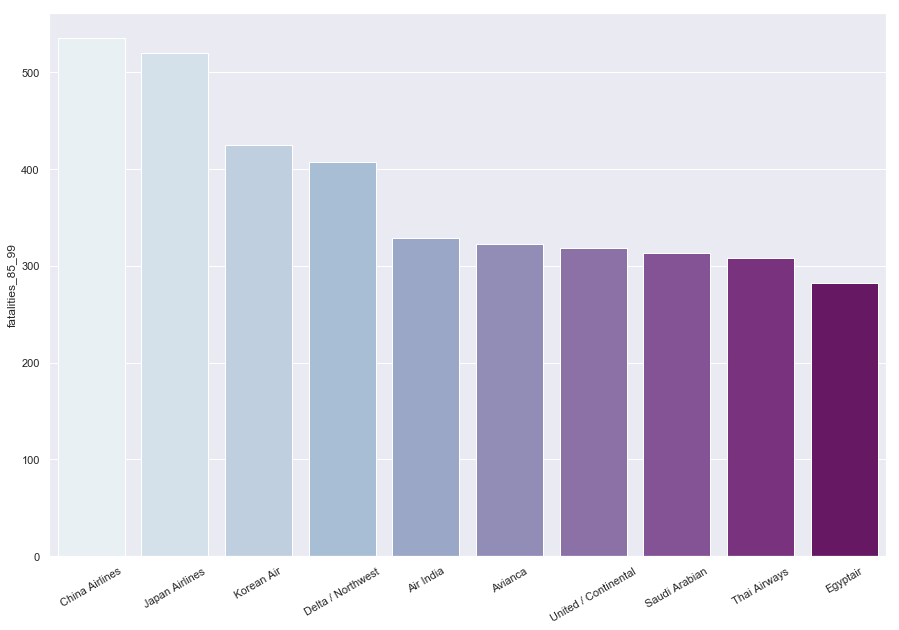

In [191]:
plt.figure(figsize=(15,10))
sb.set(font_scale=1)  
g = sb.barplot(airline_fatalities_85, sorted_85, palette= sb.color_palette("BuPu", 10))
g.set_xticklabels(g.get_xticklabels(), rotation=30)


In [77]:
sorted_00_index = sorted_00.index.tolist()

Similarly, the airlines that had the most number of fatalities in the 2000-2014 period are shown below.

In [156]:
airline_fatalities_00 = []
for item in sorted_00_index:
    print(df.airline.iloc[item])
    airline_fatalities_00.append(df.airline.iloc[item])

Malaysia Airlines
American*
Air France
Kenya Airways
China Airlines
TAM
Air India*
Gulf Air
SAS*
United / Continental*


In [169]:
airline_fatalities_00 = list(map(lambda each:each.strip("*"), airline_fatalities_00))

[Text(0,0,'Malaysia Airlines'),
 Text(0,0,'American'),
 Text(0,0,'Air France'),
 Text(0,0,'Kenya Airways'),
 Text(0,0,'China Airlines'),
 Text(0,0,'TAM'),
 Text(0,0,'Air India'),
 Text(0,0,'Gulf Air'),
 Text(0,0,'SAS'),
 Text(0,0,'United / Continental')]

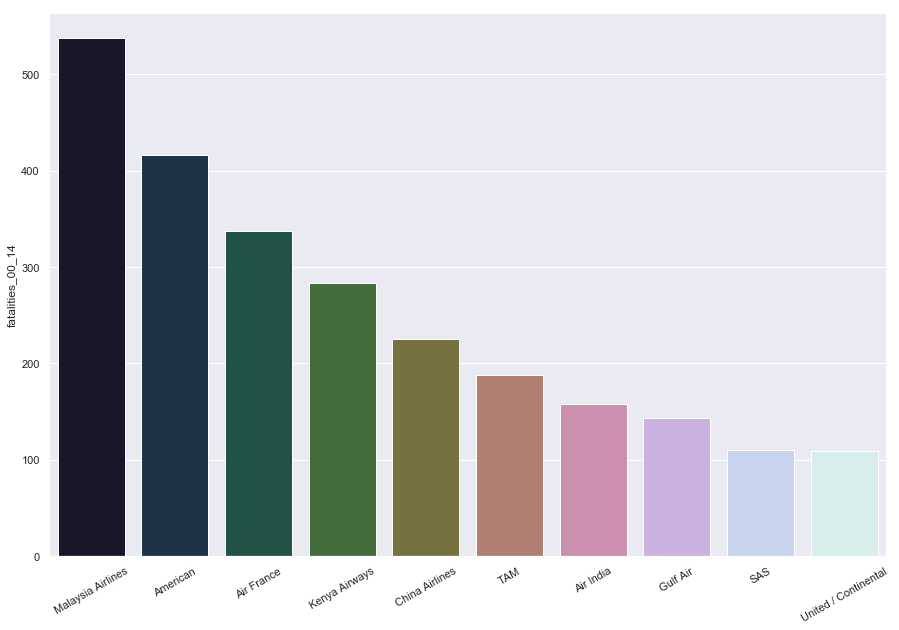

In [170]:
plt.figure(figsize=(15,10))
sb.set(font_scale=1)  #
g = sb.barplot(airline_fatalities_00, sorted_00,palette="cubehelix")
g.set_xticklabels(g.get_xticklabels(), rotation=30)

Let's find out which airlines had most fatalities (defined as per our criteria of being in the top 10 list out of 56 airlines) consistently in both periods.

In [173]:
common = [i for i in sorted_85_index if i in sorted_00_index]
for i in common:
    print(df.airline.iloc[i], df.fatalities_85_99.iloc[i], df.fatalities_00_14.iloc[i])

China Airlines 535 225
Air India* 329 158
United / Continental* 319 109


In [171]:
common

[16, 6, 51]

Text(0,0.5,'fatalities_00_14')

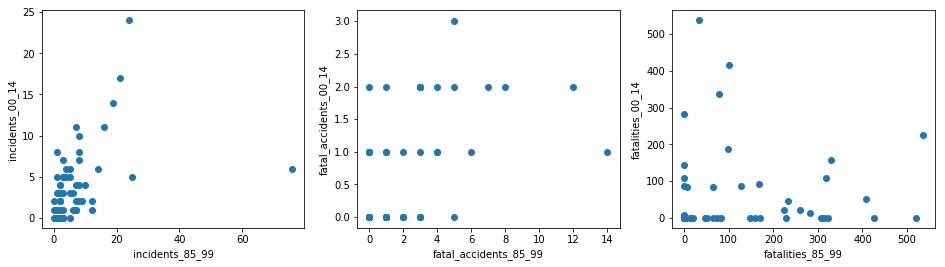

In [40]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

ax1.scatter(df.incidents_85_99, df.incidents_00_14)
ax1.set_xlabel('incidents_85_99')
ax1.set_ylabel('incidents_00_14')

ax2.scatter(df.fatal_accidents_85_99, df.fatal_accidents_00_14)
ax2.set_xlabel('fatal_accidents_85_99')
ax2.set_ylabel('fatal_accidents_00_14')

ax3.scatter(df.fatalities_85_99, df.fatalities_00_14)
ax3.set_xlabel('fatalities_85_99')
ax3.set_ylabel('fatalities_00_14')

In [ ]:
# No correlation in the rate of fatalities from one period to the next. 

To start off, we can quickly analyze the correlation over time between the each of the three features.
The first graph can help us see if in general, the airlines have done something to lower the number of incidents. Clearly, there is a correlation between incidents in both halves of time. Fatal accidents and fatalities seem to not have any correlation at all. The likelihood of a crash can be dependent on the number of incidents. Since such a feature sheds some light on the service of the airline provider, it can be useful feature in predicting crashes. 

Let's plot incidents using the jointplot functionality of seaborn which will allow us to see the density of the points as well as the individual distributions of incidents over the two time periods.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


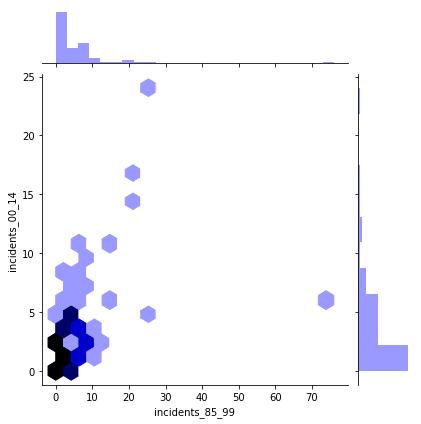

In [103]:
sb.jointplot(x=df.incidents_85_99, y=df.incidents_00_14, kind="hex", color="blue");


In [105]:
df.incidents_85_99.mean(), df.incidents_85_99.std()

(7.178571428571429, 11.035656495456639)

In [106]:
df.incidents_00_14.mean(), df.incidents_00_14.std()

(4.125, 4.544977247667823)

In [81]:
# Excluding the anomalies, there is a positive correlation in the incidents